# 基于潜在语义索引算法-LSI的电影检索
#### LSI原理：根据提供词与目标电影的语义相似度来搜索

In [3]:
import os  # 解决jupyter显示图片崩溃
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 导入依赖包

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

## 打印数据

In [5]:
df_movies = pd.read_csv('./input/movies.csv',skiprows=50, nrows=51,  sep=',', names=['rank','title','genre',"wiki_plot", "imdb_plot"],lineterminator="\n")
df_movies.head()

,rank,title,genre,wiki_plot,imdb_plot
0,49,Jaws,"[u' Drama', u' Thriller']",A young woman named Chrissie Watkins leaves an...,"Late one night, on one of the many beaches of ..."
1,50,Braveheart,"[u' Action', u' Biography', u' Drama', u' Hist...","In 1280, King Edward ""Longshanks"" (Patrick Mcg...","In the 13th Century England, after several yea..."
2,51,"The Good, the Bad and the Ugly",[u' Western'],\n\n\nThis section needs an improved plot summ...,The film tells the story of three men who purs...
3,52,Butch Cassidy and the Sundance Kid,"[u' Biography', u' Crime', u' Western']","In late 1890s Wyoming, Butch Cassidy (Paul New...","Wyoming, c. 1900s. Butch Cassidy (Paul Newman)..."
4,53,The Treasure of the Sierra Madre,"[u' Action', u' Adventure', u' Drama', u' West...","Dobbs (Humphrey Bogart) and Curtin (Tim Holt),...",Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...


## 数据清理和预处理
### 借re正则匹配删除

In [6]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS  ## 除去暂停词，如i he am we...

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

C:\ProgramData\Anaconda3\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## 调用spacy_tokenizer，开始清洗文本

In [7]:
print ('Cleaning and Tokenizing...')
%time df_movies['wiki_plot_tokenized'] = df_movies['wiki_plot'].map(lambda x: spacy_tokenizer(x))

df_movies.head() 

Cleaning and Tokenizing...
Wall time: 11.4 s


,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized
0,49,Jaws,"[u' Drama', u' Thriller']",A young woman named Chrissie Watkins leaves an...,"Late one night, on one of the many beaches of ...","[young, woman, chrissie, watkins, leave, eveni..."
1,50,Braveheart,"[u' Action', u' Biography', u' Drama', u' Hist...","In 1280, King Edward ""Longshanks"" (Patrick Mcg...","In the 13th Century England, after several yea...","[king, edward, longshanks, patrick, mcgoohan, ..."
2,51,"The Good, the Bad and the Ugly",[u' Western'],\n\n\nThis section needs an improved plot summ...,The film tells the story of three men who purs...,"[section, need, improved, plot, summary, june,..."
3,52,Butch Cassidy and the Sundance Kid,"[u' Biography', u' Crime', u' Western']","In late 1890s Wyoming, Butch Cassidy (Paul New...","Wyoming, c. 1900s. Butch Cassidy (Paul Newman)...","[late, wyoming, butch, cassidy, paul, newman, ..."
4,53,The Treasure of the Sierra Madre,"[u' Action', u' Adventure', u' Drama', u' West...","Dobbs (Humphrey Bogart) and Curtin (Tim Holt),...",Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,"[dobbs, humphrey, bogart, curtin, tim, holt, c..."


In [8]:
movie_plot = df_movies['wiki_plot_tokenized']
movie_plot[0:5]

0    [young, woman, chrissie, watkins, leave, eveni...
1    [king, edward, longshanks, patrick, mcgoohan, ...
2    [section, need, improved, plot, summary, june,...
3    [late, wyoming, butch, cassidy, paul, newman, ...
4    [dobbs, humphrey, bogart, curtin, tim, holt, c...
Name: wiki_plot_tokenized, dtype: object

## 对所有电影的词汇成词云图

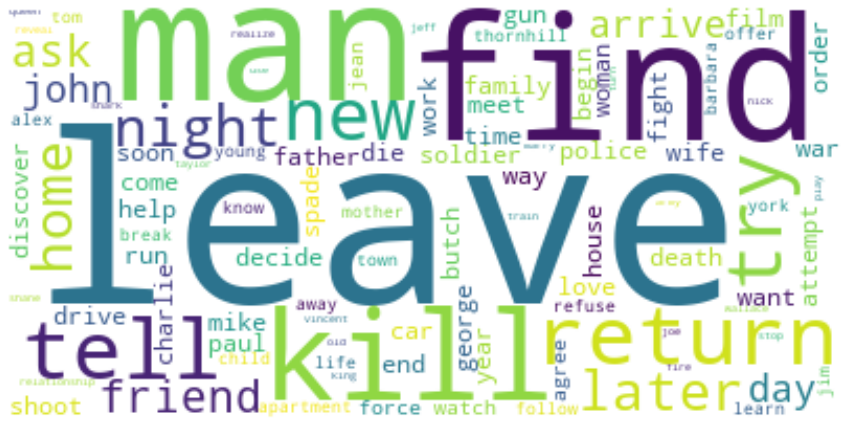

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 基于所有词利用gensim构建词汇表，每个单词都有唯一id
### gensim：用于从原始的非结构化的文本中，无监督地学习到文本隐层的主题向量表达。

In [10]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

Wall time: 31 ms


## 打印字典中排名前50的条目和它们唯一的id

In [11]:
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['aboard', 0], ['accident', 1], ['aim', 2], ['alive', 3], ['allow', 4], ['amateur', 5], ['amity', 6], ['amitys', 7], ['approach', 8], ['arrive', 9], ['ask', 10], ['atlantic', 11], ['attach', 12], ['attack', 13], ['attempt', 14], ['attention', 15], ['attract', 16], ['attribute', 17], ['autopsy', 18], ['away', 19], ['backward', 20], ['barrel', 21], ['beach', 22], ['believe', 23], ['belong', 24], ['ben', 25], ['biologist', 26], ['blow', 27], ['boat', 28], ['bounty', 29], ['boy', 30], ['brody', 31], ['brodys', 32], ['cabin', 33], ['cage', 34], ['catch', 35], ['cause', 36], ['chase', 37], ['chief', 38], ['children', 39], ['chrissie', 40], ['chrissies', 41], ['chum', 42], ['circle', 43], ['climb', 44], ['close', 45], ['coast', 46], ['come', 47], ['consequently', 48], ['contain', 49], ['content', 50]]]


## 利用Bag of Words（词袋）模型来提取文本特征，任务如下：
### 1.已知单词的词汇量

### 2.对已知单词存在度的测量

### 字典的doc2bow函数，遍历文本中的所有单词，如果单词已经存在于语料库中，它增加频率计数，否则它将单词插入语料库并将其频率计数设置为1

In [12]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('aboard', 2), ('accident', 2), ('aim', 2), ('alive', 2), ('allow', 2), ('amateur', 2), ('amity', 4), ('amitys', 2), ('approach', 2), ('arrive', 2), ('ask', 2), ('atlantic', 2), ('attach', 2), ('attack', 8), ('attempt', 4), ('attention', 2), ('attract', 2), ('attribute', 2), ('autopsy', 2), ('away', 2), ('backward', 2), ('barrel', 6), ('beach', 12), ('believe', 2), ('belong', 2), ('ben', 2), ('biologist', 2), ('blow', 2), ('boat', 18), ('bounty', 2), ('boy', 4), ('brody', 24), ('brodys', 2), ('cabin', 2), ('cage', 7), ('catch', 4), ('cause', 2), ('chase', 2), ('chief', 2), ('children', 2), ('chrissie', 4), ('chrissies', 2), ('chum', 3), ('circle', 2), ('climb', 2), ('close', 4), ('coast', 3), ('come', 2), ('consequently', 2), ('contain', 2), ('content', 2), ('crush', 2), ('damage', 4), ('dark', 2), ('dead', 2), ('death', 2), ('deck', 4), ('deputy', 2), ('desperate', 2), ('destroy', 2), ('determine', 2), ('dipping', 3), ('disappear', 2), ('discover', 4), ('don', 2), ('drag', 4), ('dra

## 利用TF_IDF来选择最匹配的词；一旦TF_IDF被构建，之后传递给LSI模型，并指定要构建的特征的数量


### LSI是一个基于奇异值分解（SVD）的方法来得到句子的特征的主题模型，目的是对文字建立出隐含特征
### 其他主题模型：LDA、HDP等

In [13]:
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

Wall time: 17 ms
Wall time: 537 ms


In [14]:
%time gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

Wall time: 102 ms
Wall time: 72 ms


In [15]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

MmCorpus(51 documents, 5380 features, 12776 non-zero entries)
MmCorpus(51 documents, 51 features, 2601 non-zero entries)


In [16]:
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

Wall time: 8 ms


## 用于搜索索引、排序并返回结果的search_similar_movies函数

In [17]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['wiki_plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

In [24]:
search_similar_movies('king ')

,Relevance,Movie Title,Movie Plot
0,92.98,The King's Speech,"Prince Albert, Duke of York, the second son of..."
1,32.61,Braveheart,"In 1280, King Edward ""Longshanks"" (Patrick Mcg..."
2,18.18,It Happened One Night,"Spoiled heiress Ellen ""Ellie"" Andrews has elop..."
3,13.02,Platoon,"In 1967, Chris Taylor has dropped out of colle..."
4,8.92,All Quiet on the Western Front,\n\n\n\n\nThis section's plot summary may be t...


In [18]:
# search for movie tiles that are related to below search parameters
search_similar_movies('crime and drugs ')

,Relevance,Movie Title,Movie Plot
0,88.13,Goodfellas,"Henry Hill (Liotta) admits, ""As far back as I ..."
1,36.53,The French Connection,"In Marseille, an undercover detective is follo..."
2,33.78,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
3,11.58,The Green Mile,"In a Louisiana nursing home in 1999, Paul Edge..."
4,8.14,Taxi Driver,"Travis Bickle, an honorably discharged U.S. Ma..."
